...welcome back!


#TITANIC Part II

##Machine Learning from Disaster: Introduction to Scikit-Learn


This tutorial is based on the Kaggle Competition, "Predicting Survival Aboard the Titanic"    
https://www.kaggle.com/c/titanic    

As well as the following tutorials:    
https://www.kaggle.com/mlchang/titanic/logistic-model-using-scikit-learn/run/91385    
https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests    
https://github.com/savarin/pyconuk-introtutorial/tree/master/notebooks    

See also:    
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html    
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html    
http://scikit-learn.org/stable/modules/svm.html      

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.io.sql as pd_sql
import sqlite3 as sql

%matplotlib inline

In [2]:
# re-establish database connection
con = sql.connect("titanic.db") 

# extract everything from the 'training_data' table (or whatever you called it) into a dataframe
train = pd_sql.read_sql('select * from training_data', con, index_col='index')

In [3]:
#Is it all still here?
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
index,,,,,,,,,,,
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,None,S


### Creating a Model: A Naive Approach    

Let's start by creating a model that predicts purely based on gender

In [7]:
# Set some variables
number_passengers = train.shape[0] 
number_survived = len(train[train.Survived == 1])

# What proportion of the passengers survived?
proportion_survived = float(number_survived) / number_passengers
print 'The proportion of passengers who survived is %s.' % proportion_survived

The proportion of passengers who survived is 0.383838383838.


In [8]:
# How can we determine what proportion of the women and of the men who survived?
# Let's start by segregating the men and women
women = train[train.Sex == "female"]
men = train[train.Sex != "female"]

# Determine the proportion of women who survived
proportion_women_survived = float(len(women[women.Survived == 1])) / len(women)
print 'The proportion of women who survived is %s.' % proportion_women_survived

# Determine the proportion of men who survived
proportion_men_survived = float(len(men[men.Survived == 1])) / len(men)
print 'The proportion of men who survived is %s.' % proportion_men_survived

The proportion of women who survived is 0.742038216561.
The proportion of men who survived is 0.188908145581.


So we know that women were MUCH more likely to survive, and we could just say that our model is:
- if female => survived = 1
- if male => survived = 0

But that means our predictions are going to be wrong sometimes -- for about a quarter of the women and a fifth of the men. Let's use the Python library Scikit-learn to see if we can do a little better!

## Using Scikit-learn

Scikit-Learn is a powerful machine learning library implemented in Python with numeric and scientific computing powerhouses Numpy, Scipy, and matplotlib for extremely fast analysis of small to medium-sized data sets. It is open source, commercially usable and contains many modern machine learning algorithms for classification, regression, clustering, feature extraction, and optimization. For this reason Scikit-Learn is often the first tool in a data scientist's toolkit for machine learning of incoming data sets.

Scikit-learn will expect numeric values and no blanks, so first we need to do a bit more wrangling.

In [9]:
# 'Sex' is stored as a text value. We should convert (or 'map') it into numeric binaries 
# so it will be ready for scikit-learn.
train['Sex'] = train['Sex'].map({'male': 0,'female': 1})

In [78]:
# Scikit-learn won't be tolerant of the missing values. In the last class, we dropped
# the 'Ticket' column. Let's also drop the 'Cabin' and 'Embarked' columns
train = train.drop(['Cabin'], axis=1)
train = train.drop(['Embarked'], axis=1)

In [10]:
# Let's also drop the 'Name' column for now (though I can think of some interesting 
# data that might be embedded in those salutations...)
train = train.drop(['Name'], axis=1)

Ok, we've got a table of purely numeric data with no null values. We're ready to go.

### LOGISTIC REGRESSION

A logistic regression mathematically calculates the decision boundary between the possibilities. It looks for a straight line that represents a cutoff that most accurately represents the training data.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import cross_validation

In [13]:
# Load the test data
test = pd.read_csv("../titanic/data/test.csv") 
test["Age"] = test["Age"].fillna(train["Age"].median())

test.loc[test["Sex"] == "male", "Sex"] = 0
test.loc[test["Sex"] == "female", "Sex"] = 1

test = test.drop(['Cabin'], axis=1)
test = test.drop(['Embarked'], axis=1)
test = test.drop(['Name'], axis=1)
test = test.drop(['Ticket'], axis=1)

In [14]:
# Initialize our algorithm
alg = LogisticRegression(random_state=1)

In [15]:
# Define our predictors
predictors = ["Pclass", "Sex", "Age", "SibSp"]
expected  = train["Survived"]

# Train the algorithm using all the training data
alg.fit(train[predictors], expected)

# Make predictions using the training set -- where we already know the correct answers
predicted = alg.predict(train[predictors])

In [16]:
# Make predictions based on the test data
predictions = alg.predict(test[predictors])

# Frame your submission for Kaggle
kgl_submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })

Well that was easy!

For Kaggle, the training samples are constructed by splitting our original dataset into more than one part. But what if certain chunks of our data have more variance than others? We want to ensure that our model performs just as well regardless of the particular way the data are divided up. So let's go back and do some cross-validation splits.    

### Cross-Validation   

More on cross-validation tools inside Scikit-learn here:    
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html

In [17]:
from sklearn.cross_validation import train_test_split

In [18]:
X = train[["Pclass", "Sex", "Age", "SibSp"]]
y = train["Survived"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2)
clf = alg.fit(X_train, y_train)

In [19]:
# But how do we know whether our model is good or not? Every estimator has a 
# score method that can judge the quality of the fit (or the prediction) on new data. 
# Bigger is better.   
clf.score(X_test, y_test)

0.78212290502793291

In [20]:
# We can also ask for a classification report. 
expected   = y_test
predicted  = clf.predict(X_test)
print classification_report(expected, predicted)

             precision    recall  f1-score   support

          0       0.80      0.87      0.83       111
          1       0.75      0.63      0.69        68

avg / total       0.78      0.78      0.78       179



So how well did our Logistic Regression Model do?    

Some models will work better than others! Let's try another one.    

### RANDOM FOREST    

A random forest is a 'meta estimator'. It will fit a number of decision trees (we'll have to tell it how many) on various sub-samples of the dataset. Then it will use averaging to improve the predictive accuracy and control over-fitting.    

Read more about Random Forests here:    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
# We'll select 50 trees and opt for 'out-of-bag' samples to estimate the generalization error.
clf = RandomForestClassifier(n_estimators=50, oob_score=True) 

In [27]:
# Next split up the data with the 'train test split' method in the Cross Validation module
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# ...and then run the 'fit' method to build a forest of trees
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
clf.score(X_test, y_test)

0.8044692737430168

In [30]:
expected   = y_test
predicted  = clf.predict(X_test)
print classification_report(expected, predicted)

             precision    recall  f1-score   support

          0       0.82      0.87      0.84       108
          1       0.78      0.70      0.74        71

avg / total       0.80      0.80      0.80       179



How did we do with our Random Forest Classifier?

In [77]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, predicted)  
thresholds = np.array([0,.5,1])
survival_rate = []  
for threshold in thresholds:  
    survival_rate.append((predicted >= threshold).mean())

<function matplotlib.pyplot.show>

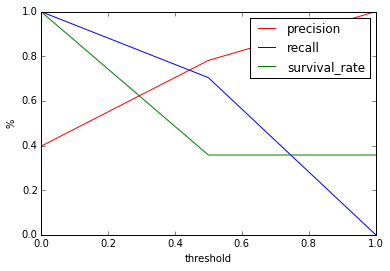

In [79]:
plt.plot(thresholds, precision, color='red')  
plt.plot(thresholds, recall, color='blue')  
plt.plot(thresholds, survival_rate, color='green')
leg = plt.legend(('precision', 'recall','survival_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  

plt.xlabel('threshold')  
plt.ylabel('%')  
plt.show

### SVM

https://github.com/rebeccabilbro/pyconuk-introtutorial/blob/master/notebooks/Section%202-2%20-%20SVM%20with%20Parameter%20Tuning.ipynb

### Mean Squared Error    

The mean squared error of an estimator measures the average difference between the expected and predicted results. An MSE of 0 -- meaning that the estimator predicts with perfect accuracy -- is the ideal, but is highly unlikely.

In [ ]:
print "Mean Squared Error: %0.3f" % mse(expected, predicted)

### Coefficient of Deterimination    

The coefficient of determination (R squared or R^2) indicates how well data fit a statistical model – sometimes simply a line or a curve. An R^2 of 1 indicates that the regression line perfectly fits the data, while an R^2 of 0 indicates that the line does not fit the data at all. This latter can be because the data is non-linear, or because it is random.

In [ ]:
print "Coefficient of Determination: %0.3f" % r2_score(expected, predicted)